In [ ]:
dbutils.fs.mount(
  source = "wasbs://data-etlproject1@storageetlproject1.blob.core.windows.net/",
  mount_point = "/mnt/transform-data",
  extra_configs = {
 "fs.azure.account.key.storageetlproject1.blob.core.windows.net": ""
 }
)

In [ ]:
dbutils.fs.ls("/mnt/transform-data/rawdata")

[FileInfo(path='dbfs:/mnt/transform-data/rawdata/titanicdataset', name='titanicdataset', size=79276, modificationTime=1717437187000)]

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
path = 'dbfs:/mnt/transform-data/rawdata/titanicdataset'
data = spark.read.format('csv').load(path, header = True)
df = data.toPandas()

In [ ]:
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.925,None,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.05,None,S


In [ ]:
#Nombre de lignes et de colonnes
df.shape

(891, 12)

In [ ]:
#type de données
df.dtypes

PassengerId    object
Survived       object
Pclass         object
Name           object
Sex            object
Age            object
SibSp          object
Parch          object
Ticket         object
Fare           object
Cabin          object
Embarked       object
dtype: object

In [ ]:
#conversion des colonnes 
columns_to_convert = ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
for column in columns_to_convert:
    df[column] = pd.to_numeric(df[column], errors='coerce')

In [ ]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [ ]:
#Valeurs manquantes pour chaque colonne
missing_values_count = df.isnull().sum()
print(missing_values_count)


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


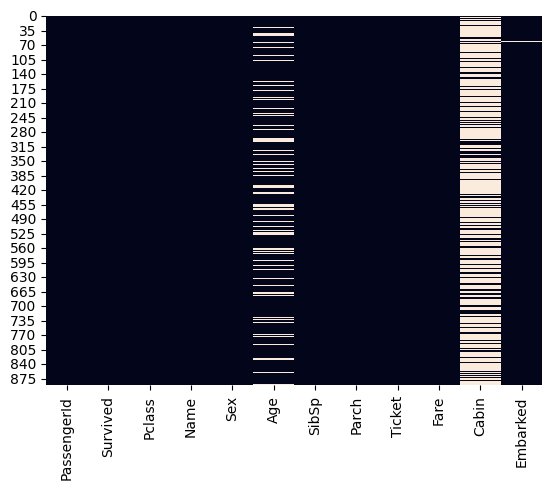

In [ ]:
#  seaborn pour visualiser les valeurs manquantes
sns.heatmap(df.isnull(), cbar=False)
plt.show()

In [ ]:
df = df.drop(columns=['Cabin'])

Analyse sur la colonne : Age

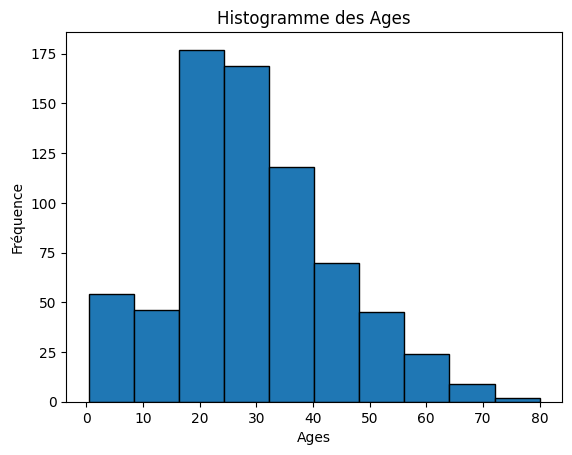

In [ ]:
plt.hist(df['Age'], bins=10, edgecolor='black')
plt.title('Histogramme des Ages')
plt.xlabel('Ages')
plt.ylabel('Fréquence')
plt.show()

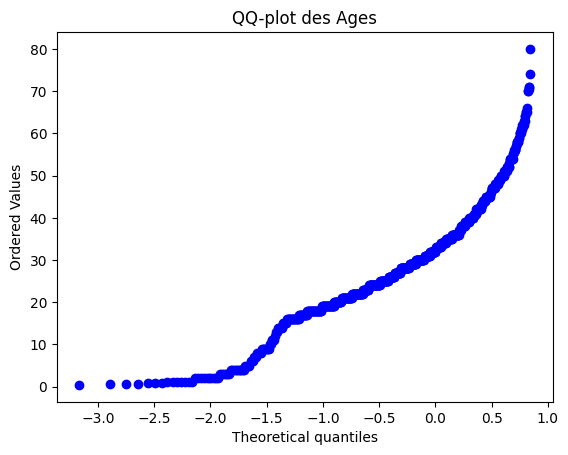

In [ ]:
import scipy.stats as stats
#3. QQ-plot (Quantile-Quantile Plot)
#Le QQ-plot compare la distribution des données à une distribution normale. Si les points suivent une ligne droite, les #données sont normalement distribuées.
# Créer un QQ-plot
stats.probplot(df['Age'], dist="norm", plot=plt)
plt.title('QQ-plot des Ages')
plt.show()

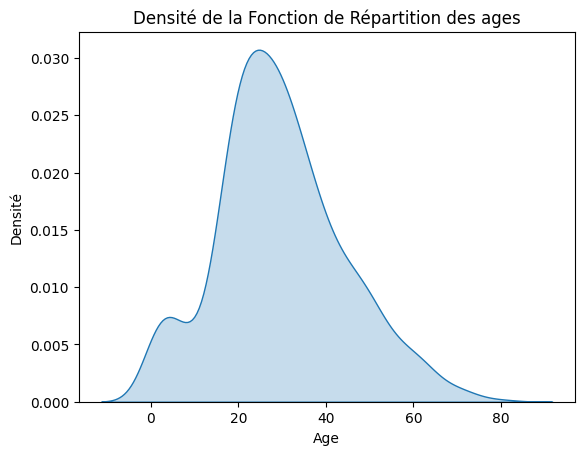

In [ ]:
import seaborn as sns
#Le KDE Plot est une estimation de la densité par noyau qui permet de visualiser la distribution continue des données.
# Créer un KDE plot
sns.kdeplot(df['Age'], shade=True)
plt.title('Densité de la Fonction de Répartition des ages')
plt.xlabel('Age')
plt.ylabel('Densité')
plt.show()

Analyse sur la colonne : Embarked

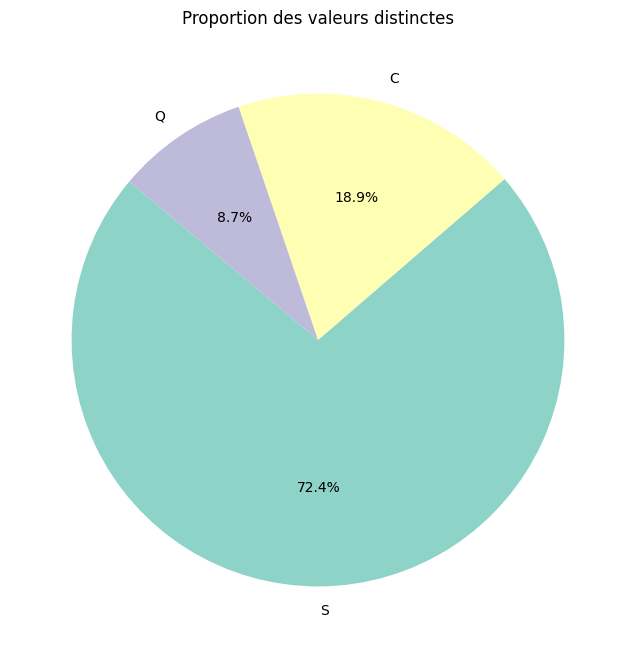

In [ ]:
# Créer un pie chart
plt.figure(figsize=(8, 8))
df['Embarked'].value_counts().plot.pie(autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set3"))
plt.title('Proportion des valeurs distinctes')
plt.ylabel('')  # Masquer l'étiquette de l'axe y
plt.show()

Analyse sur la colonne : Survived

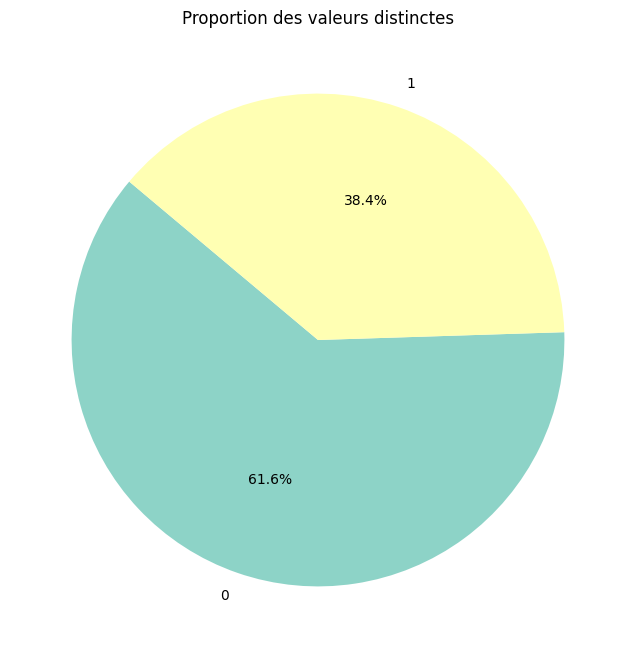

In [ ]:
plt.figure(figsize=(8, 8))
df['Survived'].value_counts().plot.pie(autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set3"))
plt.title('Proportion des valeurs distinctes')
plt.ylabel('')  # Masquer l'étiquette de l'axe y
plt.show()

Analyse dur la colonne : Pclass

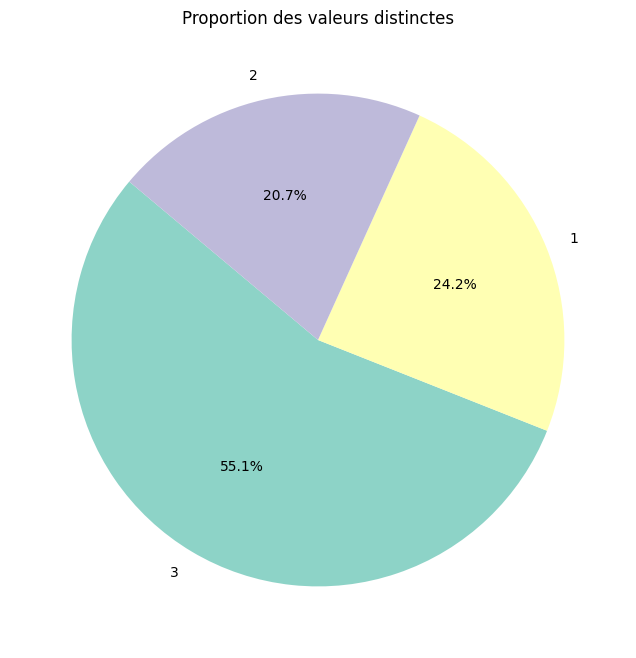

In [ ]:
plt.figure(figsize=(8, 8))
df['Pclass'].value_counts().plot.pie(autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set3"))
plt.title('Proportion des valeurs distinctes')
plt.ylabel('')  
plt.show()

Traitement sur la colonne Embarked

In [ ]:
# le mode de la colonne 'Category'
mode_value = df['Embarked'].mode()[0]
print("\nMode de la colonne 'Embarked':", mode_value)

# Remplace les valeurs manquantes par le mode
df['Embarked'] = df['Embarked'].fillna(mode_value)



Mode de la colonne 'Embarked': S


Traitement sur la colonne : Age

In [ ]:
# Remplir les valeurs manquantes avec la moyenne
df_filled_mean = df.copy()
df['Age'] = df_filled_mean['Age'].fillna(df_filled_mean['Age'].mean())

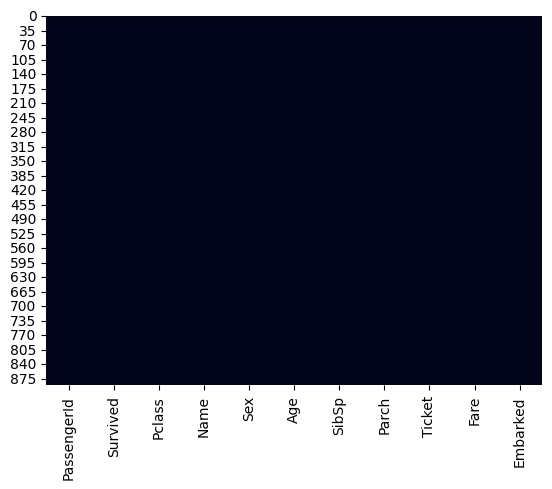

In [ ]:
sns.heatmap(df.isnull(), cbar=False)
plt.show()

In [ ]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [ ]:
df_transformed = df

In [ ]:
df_transformed.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


Chargement des données transformées dans Azure Data Lake Storage

In [ ]:
dbutils.fs.ls("/mnt/transform-data/transformeddata")

[]

In [ ]:
#chemin de destination dans ADLS Gen2
destination_path = "/mnt/transform-data/transformeddata/datatransformed.csv"

# Écriture des données dans ADLS Gen2
df_transformed.write.format("csv").option("header", "true").save(f"{destination_path}")